In [1]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bert/keras/bert_base_en_uncased/2/config.json
/kaggle/input/bert/keras/bert_base_en_uncased/2/tokenizer.json
/kaggle/input/bert/keras/bert_base_en_uncased/2/metadata.json
/kaggle/input/bert/keras/bert_base_en_uncased/2/model.weights.h5
/kaggle/input/bert/keras/bert_base_en_uncased/2/assets/tokenizer/vocabulary.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [3]:
import tensorflow as tf
import keras_core as keras
import keras_nlp
from transformers import BertTokenizer, BertForSequenceClassification

Using TensorFlow backend


In [5]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [6]:
train_df["text"].values[0:5]

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       '13,000 people receive #wildfires evacuation orders in California ',
       'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '],
      dtype=object)

In [7]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [8]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [9]:
train_df[train_df["target"] == 0]["text"].count()

4342

In [10]:
train_df[train_df["target"] == 1]["text"].count()


3271

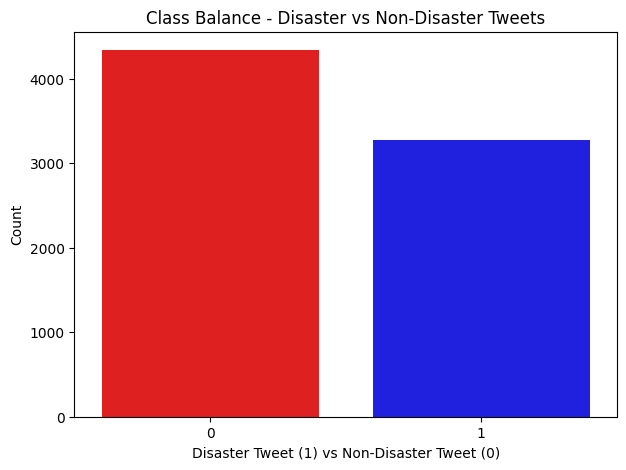

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
sns.countplot(x=train_df['target'], palette=(['red','blue']))
plt.title('Class Balance - Disaster vs Non-Disaster Tweets')
plt.xlabel('Disaster Tweet (1) vs Non-Disaster Tweet (0)')
plt.ylabel('Count')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

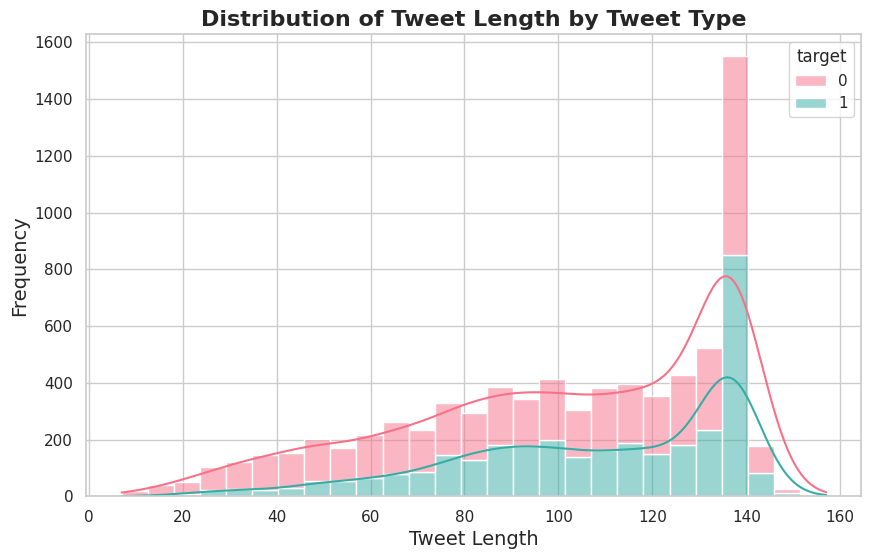

In [12]:
train_df_copy = train_df.copy()

# Calculate the length of each tweets
train_df_copy['Tweet_length'] = train_df_copy['text'].str.len()

# Set plot style
sns.set(style='whitegrid')

# Create a figure and plot the distribution of tweet lengths
plt.figure(figsize=(10, 6))

# Plot the distribution of tweet lengths for 0 and 1
sns.histplot(data=train_df_copy, x='Tweet_length', hue='target', multiple='stack', palette='husl', kde=True)

# Customize the title and label
plt.xlabel('Tweet Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Tweet Length by Tweet Type', fontsize=16, fontweight='bold')

# Show the plot
plt.show()

In [13]:
train_df["cleantext"]=train_df['text'].str.replace(r'http\S+|www.\S+', '', regex=True)
train_df["cleantext"] = train_df['text'].str.replace(r'@\w+|#\w+', '', regex=True)
train_df["cleantext"] = train_df['text'].str.replace(r'[^\w\s]', '', regex=True)

In [14]:
X=train_df["cleantext"]
y=train_df["target"]


In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
X_test=test_df["text"]

In [17]:
vectorizer=TfidfVectorizer(stop_words="english")
X_train_vector=vectorizer.fit_transform(X_train)
X_val_vector=vectorizer.transform(X_val)
X_test_vector=vectorizer.transform(X_test)

In [18]:
model =  LogisticRegression()
model.fit(X_train_vector,y_train)


LogisticRegression()

In [19]:
y_val_pred = model.predict(X_val_vector)

In [20]:
f1 = f1_score(y_val, y_val_pred)
print(f'Validation F1 Score: {f1:.4f}')

Validation F1 Score: 0.7378


In [21]:
test_predictions = model.predict(X_test_vector)

In [22]:
BATCH_SIZE = 32
EPOCHS = 5

In [23]:
preset = "bert_base_en_uncased"

preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    preset=preset,
    sequence_length=160
)

classifier = keras_nlp.models.BertClassifier.from_preset(
    preset=preset,
    preprocessor=preprocessor,
    num_classes=2
)

classifier.summary()

Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 768), (None,      │     109,482,240 │ padding_mask[0][0],        │
│                               │ None, 768)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 109,483,778 (417.65 MB)

 Trainable params: 109,483,778 (417.65 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
    verbose=0
)

In [25]:
classifier.compile(
    loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics=["accuracy"]
)

history = classifier.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/10


I0000 00:00:1727120850.162690     107 service.cc:145] XLA service 0x7aa544005da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727120850.162757     107 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1727120956.778040     107 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_105', 224 bytes spill stores, 224 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_69', 124 bytes spill stores, 124 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'copy_fusion_2', 176 bytes spill stores, 176 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_xor_fusion_235', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1727120956.892210     107 device_compiler.h:188] Compiled cluster using XLA!  This l

190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.7273 - loss: 0.5454

I0000 00:00:1727121138.383301     107 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_44', 224 bytes spill stores, 224 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_35', 124 bytes spill stores, 124 bytes spill loads



191/191 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.7279 - loss: 0.5447 - val_accuracy: 0.8378 - val_loss: 0.3893
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 91s 477ms/step - accuracy: 0.8499 - loss: 0.3665 - val_accuracy: 0.8457 - val_loss: 0.3784
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 91s 475ms/step - accuracy: 0.8862 - loss: 0.2956 - val_accuracy: 0.8411 - val_loss: 0.4002
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 91s 476ms/step - accuracy: 0.9134 - loss: 0.2355 - val_accuracy: 0.8319 - val_loss: 0.4731


In [26]:
y_val_pred = classifier.predict(X_val)

48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 210ms/step


In [27]:
f1 = f1_score(y_val, np.argmax(y_val_pred, axis=1))
print(f'Validation F1 Score: {f1:.4f}')

Validation F1 Score: 0.8078


In [30]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [31]:


sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

sample_submission.to_csv("submission.csv", index=False)
print("Your submission was successfully saved!")

102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step
Your submission was successfully saved!


In [29]:

submission = pd.DataFrame({'id': test_df['id'], 'target': test_predictions})
submission.to_csv('submission.csv', index=False)
print("Submission file created!")

Submission file created!
